In [1]:
from os import environ
from pathlib import Path
import yaml
import pandas as pd
from collections import Counter
import seaborn as sns 
import matplotlib.pyplot as plt
import librosa
from librosa import display
import numpy as np


In [5]:
wd_path = Path.cwd()
img_path = wd_path.joinpath('images')

metadata_path = wd_path.joinpath(environ['METADATA_PATH'])

audio_path = Path(environ['MEDLEYDB_PATH'])

print("wd: {}, metadata: {}, audio: {}, images {}".format(wd_path, metadata_path, audio_path, img_path))

wd: d:\Théo\GitHub\jedha-final-project\medleydb, metadata: d:\Théo\GitHub\jedha-final-project\medleydb\medleydb\data\Metadata, audio: D:\Théo\MedleyDB\V1, images d:\Théo\GitHub\jedha-final-project\medleydb\images


In [3]:
audio_files = [a.name for a in audio_path.iterdir() if a.is_dir()]

### Liste des fichiers audio de la V1

In [114]:
audio_files[:5]

['AClassicEducation_NightOwl',
 'AimeeNorwich_Child',
 'AimeeNorwich_Flying',
 'AlexanderRoss_GoodbyeBolero',
 'AlexanderRoss_VelvetCurtain']

### Parcours des metadata

In [115]:
metadata_files = [m for m in metadata_path.glob('*.yaml')]
metadata_files[:5]

[WindowsPath('d:/Théo/GitHub/medleydb/medleydb/data/Metadata/AcDc_BackInBlack_METADATA.yaml'),
 WindowsPath('d:/Théo/GitHub/medleydb/medleydb/data/Metadata/AClassicEducation_NightOwl_METADATA.yaml'),
 WindowsPath('d:/Théo/GitHub/medleydb/medleydb/data/Metadata/Adele_SomeoneLikeYou_METADATA.yaml'),
 WindowsPath('d:/Théo/GitHub/medleydb/medleydb/data/Metadata/Aerosmith_LoveInAnElevator_METADATA.yaml'),
 WindowsPath('d:/Théo/GitHub/medleydb/medleydb/data/Metadata/AHa_TakeOnMe_METADATA.yaml')]

In [116]:
metadata_filenames = [m.name.split("_METADATA")[0] for m in metadata_files]
metadata_filenames[:5]

['AcDc_BackInBlack',
 'AClassicEducation_NightOwl',
 'Adele_SomeoneLikeYou',
 'Aerosmith_LoveInAnElevator',
 'AHa_TakeOnMe']

In [117]:
match = [m for m in metadata_files if m.name.split("_METADATA")[0] in audio_files]

In [118]:
len(match)

122

### Création d'un dataframe à partir des fichiers metadata

In [9]:
metadata_df = pd.read_csv(metadata_path.joinpath("metadata.csv"), index_col=0)

In [10]:
metadata_df.head()

,album,artist,composer,excerpt,genre,has_bleed,instrumental,mix_filename,origin,producer,raw_dir,stem_dir,stems,title,version,website
0,Shaking Through Volume 2,A Classic Education,['A Classic Education'],no,Singer/Songwriter,no,no,AClassicEducation_NightOwl_MIX.wav,Weathervane Music,['Andy Williams'],AClassicEducation_NightOwl_RAW,AClassicEducation_NightOwl_STEMS,"{'S01': {'component': 'bass', 'filename': 'ACl...",Night Owl,1.2,['www.shakingthrough.com/aclassiceducation']
1,NaN,Aimee Norwich,['Aimee Norwich'],no,Singer/Songwriter,no,no,AimeeNorwich_Child_MIX.wav,Independent Artist,['Aimee Norwich & Senem Pirler'],AimeeNorwich_Child_RAW,AimeeNorwich_Child_STEMS,"{'S01': {'component': '', 'filename': 'AimeeNo...",Child,1.2,['www.aimeenorwich.com']
2,NaN,Aimee Norwich,['Aimee Norwich'],no,World/Folk,no,yes,AimeeNorwich_Flying_MIX.wav,Independent Artist,['Aimee Norwich & Senem Pirler'],AimeeNorwich_Flying_RAW,AimeeNorwich_Flying_STEMS,"{'S01': {'component': '', 'filename': 'AimeeNo...",Flying,1.2,['www.aimeenorwich.com']
3,NaN,Alexander Ross,['Alexander Ross'],no,Singer/Songwriter,no,no,AlexanderRoss_GoodbyeBolero_MIX.wav,Independent Artist,['Mike Tierney'],AlexanderRoss_GoodbyeBolero_RAW,AlexanderRoss_GoodbyeBolero_STEMS,"{'S01': {'component': '', 'filename': 'Alexand...",Goodbye Bolero,1.2,[]
4,NaN,Alexander Ross,['Alexander Ross'],no,Singer/Songwriter,no,no,AlexanderRoss_VelvetCurtain_MIX.wav,Independent Artist,['Mike Tierney'],AlexanderRoss_VelvetCurtain_RAW,AlexanderRoss_VelvetCurtain_STEMS,"{'S01': {'component': 'melody', 'filename': 'A...",Velvet Curtain,1.2,[]


## Liste exhaustive des instruments

In [11]:
# on parcours tous les stems et on ajoute les instruments à la liste
instruments_list = []
for stems in metadata_df["stems"]:
    stems = eval(stems)
    for s in stems.values():
        instruments_list.append(s["instrument"])
instruments_list = set(instruments_list)

In [12]:
instruments_list

{'Main System',
 'accordion',
 'acoustic guitar',
 'alto saxophone',
 'auxiliary percussion',
 'bamboo flute',
 'banjo',
 'baritone saxophone',
 'bass clarinet',
 'bass drum',
 'bassoon',
 'bongo',
 'brass section',
 'cello',
 'cello section',
 'chimes',
 'claps',
 'clarinet',
 'clarinet section',
 'clean electric guitar',
 'cymbal',
 'darbuka',
 'distorted electric guitar',
 'dizi',
 'double bass',
 'doumbek',
 'drum machine',
 'drum set',
 'electric bass',
 'electric piano',
 'erhu',
 'female singer',
 'flute',
 'flute section',
 'french horn',
 'french horn section',
 'fx/processed sound',
 'glockenspiel',
 'gong',
 'gu',
 'guzheng',
 'harmonica',
 'harp',
 'horn section',
 'kick drum',
 'lap steel guitar',
 'liuqin',
 'male rapper',
 'male singer',
 'male speaker',
 'mandolin',
 'melodica',
 'oboe',
 'oud',
 'piano',
 'piccolo',
 'sampler',
 'scratches',
 'shaker',
 'snare drum',
 'soprano saxophone',
 'string section',
 'synthesizer',
 'tabla',
 'tack piano',
 'tambourine',
 'teno

## Création d'un dictionnaire pour renommer les STEMS lors du pre-processing

In [13]:
instruments_dict = {i: i.replace(' ', '_') for i in instruments_list}
instruments_dict

{'dizi': 'dizi',
 'trombone section': 'trombone_section',
 'bassoon': 'bassoon',
 'cello section': 'cello_section',
 'yangqin': 'yangqin',
 'shaker': 'shaker',
 'cymbal': 'cymbal',
 'bongo': 'bongo',
 'vibraphone': 'vibraphone',
 'viola': 'viola',
 'viola section': 'viola_section',
 'violin section': 'violin_section',
 'french horn': 'french_horn',
 'piccolo': 'piccolo',
 'synthesizer': 'synthesizer',
 'flute section': 'flute_section',
 'timpani': 'timpani',
 'banjo': 'banjo',
 'bass clarinet': 'bass_clarinet',
 'string section': 'string_section',
 'female singer': 'female_singer',
 'bamboo flute': 'bamboo_flute',
 'drum machine': 'drum_machine',
 'trombone': 'trombone',
 'flute': 'flute',
 'glockenspiel': 'glockenspiel',
 'kick drum': 'kick_drum',
 'tack piano': 'tack_piano',
 'violin': 'violin',
 'tenor saxophone': 'tenor_saxophone',
 'scratches': 'scratches',
 'brass section': 'brass_section',
 'piano': 'piano',
 'alto saxophone': 'alto_saxophone',
 'cello': 'cello',
 'male speaker'

### Filtre du dataset sur les TRACKS contenant des STEMS clean electric guitar

In [14]:
clean_el_guitar_stems = []
for stems in metadata_df["stems"]:
    stems = eval(stems)
    for s in stems.values():
        if s["instrument"] == "clean electric guitar":
            clean_el_guitar_stems.append(s["filename"])
clean_el_guitar_stems

['AClassicEducation_NightOwl_STEM_05.wav',
 'AimeeNorwich_Child_STEM_03.wav',
 'AimeeNorwich_Flying_STEM_04.wav',
 'AimeeNorwich_Flying_STEM_05.wav',
 'AlexanderRoss_GoodbyeBolero_STEM_02.wav',
 'AlexanderRoss_GoodbyeBolero_STEM_03.wav',
 'AlexanderRoss_VelvetCurtain_STEM_02.wav',
 'AlexanderRoss_VelvetCurtain_STEM_03.wav',
 'AlexanderRoss_VelvetCurtain_STEM_10.wav',
 'AmarLal_Rest_STEM_01.wav',
 'Auctioneer_OurFutureFaces_STEM_05.wav',
 'CelestialShore_DieForUs_STEM_05.wav',
 'CelestialShore_DieForUs_STEM_08.wav',
 'ChrisJacoby_BoothShotLincoln_STEM_03.wav',
 'ClaraBerryAndWooldog_AirTraffic_STEM_04.wav',
 'CroqueMadame_Oil_STEM_02.wav',
 'CroqueMadame_Pilot_STEM_02.wav',
 'FacesOnFilm_WaitingForGa_STEM_05.wav',
 'FamilyBand_Again_STEM_05.wav',
 'InvisibleFamiliars_DisturbingWildlife_STEM_05.wav',
 'LizNelson_Rainfall_STEM_05.wav',
 'Lushlife_ToynbeeSuite_STEM_10.wav',
 'Lushlife_ToynbeeSuite_STEM_11.wav',
 'Lushlife_ToynbeeSuite_STEM_12.wav',
 'Meaxic_TakeAStep_STEM_02.wav',
 'Meaxic

### Création de la liste des TRACKS contenant clean electric guitar

In [15]:
clean_el_guitar_tracks = set([s.split("_STEM")[0] for s in clean_el_guitar_stems])
clean_el_guitar_tracks

{'AClassicEducation_NightOwl',
 'AimeeNorwich_Child',
 'AimeeNorwich_Flying',
 'AlexanderRoss_GoodbyeBolero',
 'AlexanderRoss_VelvetCurtain',
 'AmarLal_Rest',
 'Auctioneer_OurFutureFaces',
 'CelestialShore_DieForUs',
 'ChrisJacoby_BoothShotLincoln',
 'ClaraBerryAndWooldog_AirTraffic',
 'CroqueMadame_Oil',
 'CroqueMadame_Pilot',
 'FacesOnFilm_WaitingForGa',
 'FamilyBand_Again',
 'InvisibleFamiliars_DisturbingWildlife',
 'LizNelson_Rainfall',
 'Lushlife_ToynbeeSuite',
 'Meaxic_TakeAStep',
 'Meaxic_YouListen',
 'MusicDelta_Beatles',
 'MusicDelta_Britpop',
 'MusicDelta_Country2',
 'MusicDelta_Disco',
 'MusicDelta_Gospel',
 'MusicDelta_Reggae',
 'MusicDelta_Rock',
 'MusicDelta_Rockabilly',
 'MusicDelta_Shadows',
 'PortStWillow_StayEven',
 'SecretMountains_HighHorse',
 'Snowmine_Curfews',
 'StevenClark_Bounty',
 'TablaBreakbeatScience_MoodyPlucks',
 'TablaBreakbeatScience_Vger',
 'TheDistricts_Vermont',
 'TheScarletBrand_LesFleursDuMal'}

### Observation du component associé à chaque pistes de target

In [56]:
components_solo = []
stems_solo = []

for stems in metadata_df["stems"]:
    stems = eval(stems)
    for s in stems.values():
        components_solo.append(s["component"])
        stems_solo.append(s["filename"])

In [57]:
liste_components = []
stems_compo = zip(stems_solo, components_solo)
stems_compo = list(stems_compo)

for s in stems_compo :
    for c in clean_el_guitar_stems :
       if s[0] == c :
            liste_components.append(s[1])

In [48]:
results = zip(clean_el_guitar_stems, liste_components)
results = list(results)
Counter(liste_components)

Counter({'': 45, 'melody': 11})

### Observation de chaque mix contenant une target en fonction du 'has_bleed ou pas'

In [75]:
mix_cible = []
clean_el_guitar_tracks = list(clean_el_guitar_tracks)

for i in clean_el_guitar_tracks :
    mix_cible.append(i+('_MIX.wav'))

In [77]:
has_bleed = []
has_mix = zip(metadata_df['mix_filename'], metadata_df['has_bleed'])
has_mix = list(has)

for i in has_mix :
    for j in mix_cible :
        if i[0] == j :
            has_bleed.append(i[1])

In [79]:
results_bleed = zip(mix_cible, has_bleed)
results_bleed = sorted(list(hasb))
results_bleed

[('AClassicEducation_NightOwl_MIX.wav', 'no'),
 ('AimeeNorwich_Child_MIX.wav', 'no'),
 ('AimeeNorwich_Flying_MIX.wav', 'no'),
 ('AlexanderRoss_GoodbyeBolero_MIX.wav', 'no'),
 ('AlexanderRoss_VelvetCurtain_MIX.wav', 'no'),
 ('AmarLal_Rest_MIX.wav', 'no'),
 ('Auctioneer_OurFutureFaces_MIX.wav', 'no'),
 ('CelestialShore_DieForUs_MIX.wav', 'no'),
 ('ChrisJacoby_BoothShotLincoln_MIX.wav', 'no'),
 ('ClaraBerryAndWooldog_AirTraffic_MIX.wav', 'no'),
 ('CroqueMadame_Oil_MIX.wav', 'no'),
 ('CroqueMadame_Pilot_MIX.wav', 'no'),
 ('FacesOnFilm_WaitingForGa_MIX.wav', 'no'),
 ('FamilyBand_Again_MIX.wav', 'yes'),
 ('InvisibleFamiliars_DisturbingWildlife_MIX.wav', 'yes'),
 ('LizNelson_Rainfall_MIX.wav', 'no'),
 ('Lushlife_ToynbeeSuite_MIX.wav', 'no'),
 ('Meaxic_TakeAStep_MIX.wav', 'no'),
 ('Meaxic_YouListen_MIX.wav', 'no'),
 ('MusicDelta_Beatles_MIX.wav', 'no'),
 ('MusicDelta_Britpop_MIX.wav', 'no'),
 ('MusicDelta_Country2_MIX.wav', 'no'),
 ('MusicDelta_Disco_MIX.wav', 'yes'),
 ('MusicDelta_Gospel_MIX.

### Visualisations

In [87]:
liste_components = [i.replace('melody', '1') for i in liste_components]
df1 = pd.DataFrame(liste_components) 

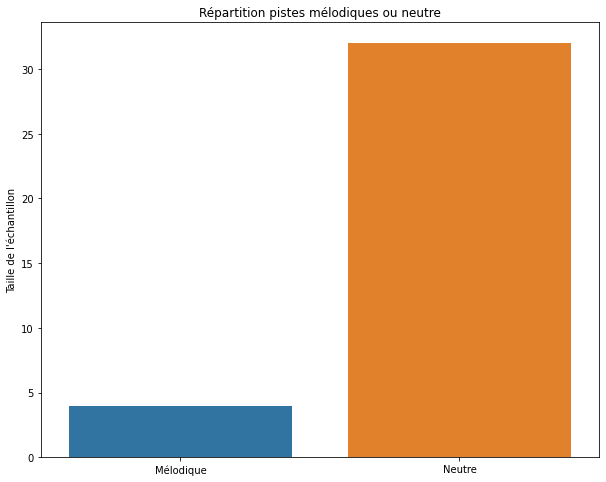

In [120]:
# 11 pistes sont en mélodie, 45 ne sont rien (ni bass, ni mélodie).

plt.figure(figsize=(10,8))
g = sns.barplot(x=df.value_counts(),y=df.value_counts()).set_title('Répartition pistes mélodiques ou neutre')
plt.ylabel("Taille de l'échantillon")
ax = plt.subplot()
ax = ax.set_xticklabels(["Mélodique","Neutre"])

In [83]:
has_bleed = [i.replace('yes', '1') for i in has_bleed]
has_bleed = [i.replace('no', '0') for i in has_bleed]
df = pd.DataFrame(has_bleed) 

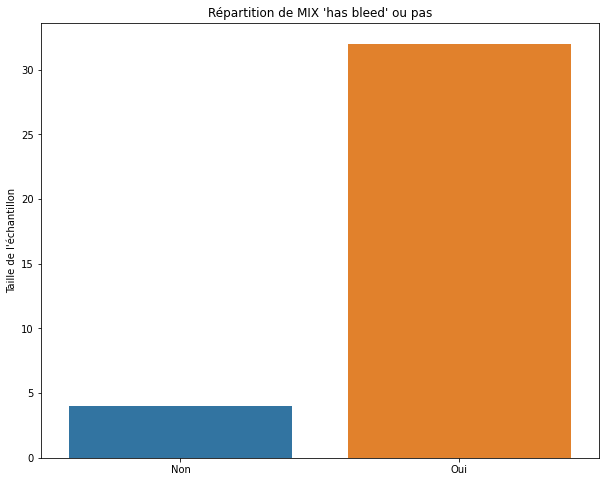

In [106]:
# 32 MIX qui ne sont pas 'has bleed', 4 MIX le sont

plt.figure(figsize=(10,8))
g = sns.barplot(x=df.value_counts(),y=df.value_counts()).set_title("Répartition de MIX 'has bleed' ou pas")
plt.ylabel("Taille de l'échantillon")
ax = plt.subplot()
ax = ax.set_xticklabels(["Non","Oui"])
# save(img_path.joinpath("mon_graphe.png"))

In [190]:
librosa.load('D:\Théo\MedleyDB\V1\AClassicEducation_NightOwl\AClassicEducation_NightOwl_STEMS\AClassicEducation_NightOwl_STEM_01.wav')

(array([-3.1314936e-04, -5.1763438e-04, -1.4932302e-04, ...,
         4.8623560e-06, -2.5242332e-06,  1.3548863e-06], dtype=float32),
 22050)

In [1]:
y, sr = librosa.load('D:\Théo\MedleyDB\V1\AClassicEducation_NightOwl\AClassicEducation_NightOwl_STEMS\AClassicEducation_NightOwl_STEM_01.wav', duration=15)
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True)
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
img = librosa.display.specshow(D, y_axis='linear', x_axis='time',
                               sr=sr, ax=ax)
ax.set(title='Linear-frequency power spectrogram')
ax.label_outer()
plt.show()

NameError: name 'librosa' is not defined

In [ ]:
def contains_guitar(f):
    f = eval(f)
    return "clean electric guitar" in [f[c]["instrument"] for c in f]

In [ ]:
instru.loc[:, "guitar"] = instru.loc[:, "stems"]

In [ ]:
instru.loc[:, "guitar"] = instru["guitar"].map(contains_guitar)

In [ ]:
instru[instru["guitar"] == 1]